<a href="https://colab.research.google.com/github/jeongminia/Cancer-Classification/blob/main/weekly/week4/0930_jm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암환자 유전체 데이터 기반 암종 분류 AI 모델 개발


# library loading

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.metrics import f1_score

# macro f1 score 함수
def macro_f1_score(y_true, y_pred, n_classes = 25):
    f1_scores = []
    for c in range(n_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return np.mean(f1_scores)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -qq '/content/drive/MyDrive/0000/dacon_biodata/open.zip'

# data loading

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [24]:
train.tail(5)

ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10  ZWINT ZYX  
6196     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6197     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6198     WT     WT     WT     WT    WT    WT   WT   WT  T181S  WT  
6199     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6200     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  

[5 rows x 4386 columns]

In [25]:
test.head(5)

ID A2M AAAS AADAT AARS1 ABAT  ABCA1 ABCA2 ABCA3 ABCA4  ... ZNF292  \
0  TEST_0000  WT   WT    WT    WT   WT     WT    WT    WT    WT  ...     WT   
1  TEST_0001  WT   WT    WT    WT   WT  R587Q    WT    WT    WT  ...     WT   
2  TEST_0002  WT   WT    WT    WT   WT     WT    WT    WT    WT  ...     WT   
3  TEST_0003  WT   WT    WT    WT   WT     WT    WT    WT    WT  ...     WT   
4  TEST_0004  WT   WT    WT    WT   WT     WT    WT    WT    WT  ...     WT   

  ZNF365 ZNF639 ZNF707 ZNFX1    ZNRF4 ZPBP ZW10 ZWINT ZYX  
0     WT     WT     WT    WT       WT   WT   WT    WT  WT  
1     WT     WT     WT    WT  I383Sfs   WT   WT    WT  WT  
2     WT     WT     WT    WT       WT   WT   WT    WT  WT  
3     WT     WT     WT    WT       WT   WT   WT    WT  WT  
4     WT     WT     WT    WT       WT   WT   WT    WT  WT  

[5 rows x 4385 columns]

In [53]:
len(train), len(test)

(6201, 2546)

# preprocessing

1. 결측값 처리
2. 유전체 변이

  2.1. WT 패턴 처리
  
  2.2. 단순 패턴 처리 : 일반적 변이

  2.3. too long suffix
  
  2.4. 특이 패턴 처리 : '_' 가 속해있는 경우 다른 카테고리로 진행

3. 파생변수 생성

### 결측값 처리

In [26]:
# NaN 개수와 위치 확인
train_nan = train.isna().sum().sum()
train_nan_columns = train.columns[train.isna().any()].tolist()
print(f"train NaN 개수: {train_nan}")
print("NaN 값이 있는 열:")
print(train_nan_columns)

test_nan = test.isna().sum().sum()
test_nan_columns = test.columns[test.isna().any()].tolist()
print(f"test NaN 개수: {test_nan}")
print("NaN 값이 있는 열:")
print(test_nan_columns)

train NaN 개수: 0
NaN 값이 있는 열:
[]
test NaN 개수: 237
NaN 값이 있는 열:
['AK2', 'ATP6V1H', 'CCRL2', 'CFP', 'CNOT2', 'CRAT', 'DPYSL4', 'GUK1', 'IER3', 'INHBB', 'KCNH1', 'MYL1', 'NDUFV1', 'NUDT4', 'POLD2', 'PTCH1', 'PTGES3', 'RBM5', 'SCAMP1', 'SCNN1A', 'SLC25A28', 'SYBU', 'TARS1', 'TMEM97', 'TNFAIP6']


In [27]:
# NaN 값을 'WT'로 치환
train.fillna('WT', inplace=True)
test.fillna('WT', inplace=True)

print()

train_nan = train.isna().sum().sum()
print(f"처리 후 train NaN 개수: {train_nan}")

test_nan = test.isna().sum().sum()
print(f"처리 후 test NaN 개수: {test_nan}")


처리 후 train NaN 개수: 0
처리 후 test NaN 개수: 0


### 유전체 동의성 변이

#### 1. WT 패턴 처리

In [28]:
# 패턴을 구분하는 함수 정의
def process_value(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    # 2) 복합 패턴 처리를 위한 split
    parts = value.split()  # 공백 기준
    processed_parts = []

    for part in parts:
        # 숫자 앞뒤로 같은 패턴이 있는지 확인
        match = re.match(r'([^\d]+)(\d+)([^\d]+)', part)
        if match:
            prefix, number, suffix = match.groups()

            # Prefix나 Suffix에 숫자가 있는지 확인
            if re.search(r'\d', prefix) or re.search(r'\d', suffix):
                mismatch.append(part)
                continue

            # 앞뒤 문자가 같다면 해당 부분 무시
            if prefix == suffix and prefix != 'fs':
                continue

            # 유니크한 접두사와 접미사를 추가
            alphabets_p.append(prefix)  # 접두사 추가
            alphabets_s.append(suffix)  # 접미사 추가


            if len(prefix)>1:
                toolong.append(part)
                toolong_pre.append(prefix)
                toolong_suf.append(suffix)

        else:
            # 패턴이 없다면 그대로 추가
            mismatch.append(part)

        processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

##### train

In [29]:
# 일반 형식(ex.R385R) 에 매칭되지 않는 것 확인
mismatch = []

# 접두사 접미사의 알파벳이 아미노산 기호가 맞는지 확인
alphabets_p = []
alphabets_s = []

# 접두사 접미사가 긴 변이 확인
toolong = []
toolong_pre = []
toolong_suf = []

# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value)

# 최종 데이터 확인
train.head()

ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0  TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1  TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2  TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3  TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4  TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   

  ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10 ZWINT ZYX  
0     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  
1     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  
2     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  
3     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  
4     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  

[5 rows x 4386 columns]

##### test

In [30]:
# 일반 형식(ex.R385R) 에 매칭되지 않는 것 확인
mismatch = []

# 접두사 접미사의 알파벳이 아미노산 기호가 맞는지 확인
alphabets_p = []
alphabets_s = []

# 접두사 접미사가 긴 변이 확인
toolong = []
toolong_pre = []
toolong_suf = []

# test 데이터프레임 전처리
for col in test.columns[2:]:  # ID와 SUBCLASS 제외
    test[col] = test[col].apply(process_value)

# 최종 데이터 확인
test.head()

ID A2M AAAS AADAT AARS1 ABAT  ABCA1 ABCA2 ABCA3 ABCA4  ... ZNF292  \
0  TEST_0000  WT   WT    WT    WT   WT     WT    WT    WT    WT  ...     WT   
1  TEST_0001  WT   WT    WT    WT   WT  R587Q    WT    WT    WT  ...     WT   
2  TEST_0002  WT   WT    WT    WT   WT     WT    WT    WT    WT  ...     WT   
3  TEST_0003  WT   WT    WT    WT   WT     WT    WT    WT    WT  ...     WT   
4  TEST_0004  WT   WT    WT    WT   WT     WT    WT    WT    WT  ...     WT   

  ZNF365 ZNF639 ZNF707 ZNFX1    ZNRF4 ZPBP ZW10 ZWINT ZYX  
0     WT     WT     WT    WT       WT   WT   WT    WT  WT  
1     WT     WT     WT    WT  I383Sfs   WT   WT    WT  WT  
2     WT     WT     WT    WT       WT   WT   WT    WT  WT  
3     WT     WT     WT    WT       WT   WT   WT    WT  WT  
4     WT     WT     WT    WT       WT   WT   WT    WT  WT  

[5 rows x 4385 columns]

#### 2. 단순 패턴 처리

- missense ← 알파벳숫자**알파벳** (치환)
- nonsense ← 알파벳숫자 * (조기종결)
- deletion ← 알파벳숫자**del** (삭제)
- insertion ← **-**숫자알파벳 or 알파벳숫자**ins** (삽입)
- frameshift ← 알파벳숫자**fs**
- delins ← 알파벳숫자**delins**알파벳 (집단치환)

In [31]:
# 패턴을 구분하는 함수 정의
def process_value(value):
    # 1) 'WT'는 그대로 유지
    if value == 'WT':
        return value

    # 2) 복합 패턴 처리를 위한 split
    parts = value.split()  # 공백 기준으로 나눔
    processed_parts = []

    for part in parts:
        # 기존 형태에 매칭되는 아이들 중
        match = re.match(r'([^\d]+)(\d+)([^\d]+)', part)

        if match:
            # Missense
            if re.match(r'([A-Z])(\d+)([A-Z])$', part):
                processed_parts.append(f"missense")
                missense.append(part)

            # Nonsense
            elif re.match(r'([A-Z])(\d+)\*$', part):
                processed_parts.append(f"nonsense")
                nonsense.append(part)

            # Deletion
            elif re.match(r'([A-Z])(\d+)del$', part):
                processed_parts.append(f"deletion")
                deletion.append(part)

            # Insertion (삽입) 패턴 1: - 숫자 알파벳
            elif re.match(r'-\d+[A-Z]+$', part):
                processed_parts.append(f"insertion")
                insertion.append(part)

            # Insertion (삽입) 패턴 2: 알파벳 숫자 ins
            elif re.match(r'([A-Z])(\d+)ins$', part):
                processed_parts.append(f"insertion")
                insertion.append(part)

            # Frameshift (프레임시프트) 패턴: 접두사 여러 알파벳, 숫자, fs 앞에 다른 알파벳 허용
            elif re.match(r'([A-Z\-\*]+)(\d+)[A-Z]*fs$', part):
                processed_parts.append(f"frameshift")
                frameshift.append(part)

            # Delins (집단치환) 패턴: 알파벳 숫자 delins 알파벳
            elif re.match(r'([A-Z]+)(\d+)delins([A-Z]+)$', part):
                processed_parts.append(f"delins")
                delins.append(part)

            else:
                # 패턴이 없다면 그대로 추가
                mismatch.append(part)

    if not processed_parts:
        result = 'WT'
        strange = []
    else:
        result = ' '.join(processed_parts)

    return result

In [32]:
# 결과 처리
mismatch = []
missense = []
nonsense = []
deletion = []
insertion = []
frameshift = []
delins = []
strange = []

# test 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value)

# 결과 출력
print()
print("Mismatch:", mismatch)
print("Missense:", missense)
print("Nonsense:", nonsense)
print("Deletion:", deletion)
print("Insertion:", insertion)
print("Frameshift:", frameshift)
print("Delins:", delins)
print("Strange:", strange)

train.head(20)


Mismatch: []
Missense: ['E1462K', 'K289T', 'I175F', 'S660R', 'P799S', 'L621P', 'M713I', 'Q1051H', 'D638N', 'I984S', 'F352S', 'F572L', 'F229L', 'I481N', 'A1061V', 'L19P', 'E153K', 'T885A', 'F495L', 'M121I', 'D897H', 'L311P', 'D641E', 'S63F', 'S1249F', 'E1311K', 'E342K', 'R147C', 'E1311K', 'E342K', 'R147C', 'T411S', 'R719H', 'V207L', 'R732Q', 'C1321Y', 'P529H', 'V551M', 'R174H', 'R174H', 'Y1104D', 'P92T', 'L13I', 'S782C', 'A1108T', 'P380Q', 'L1067I', 'K1176M', 'G852R', 'I1091T', 'S785P', 'Y1055C', 'T1229S', 'G69E', 'Q1220H', 'E1137Q', 'P700A', 'F1028V', 'M121V', 'R1122H', 'H156Y', 'P36S', 'G1094V', 'I984S', 'N1038T', 'F365L', 'T728M', 'R732Q', 'R732Q', 'S191Y', 'P969S', 'G69R', 'L965R', 'S276F', 'I1091V', 'T1285I', 'H446N', 'E184D', 'M1385T', 'A1043T', 'T548I', 'R174H', 'R1034S', 'N1413K', 'D1420N', 'K271N', 'N159Y', 'F155I', 'S351A', 'P1306Q', 'R1031Q', 'P1306Q', 'P759T', 'E518G', 'C48R', 'S571R', 'A1061V', 'R147H', 'M1314I', 'F1248L', 'A176T', 'S660R', 'S525F', 'D282N', 'R147C', 'R147

ID SUBCLASS A2M AAAS     AADAT AARS1 ABAT              ABCA1  \
0   TRAIN_0000    KIPAN  WT   WT        WT    WT   WT                 WT   
1   TRAIN_0001     SARC  WT   WT        WT    WT   WT                 WT   
2   TRAIN_0002     SKCM  WT   WT        WT    WT   WT                 WT   
3   TRAIN_0003     KIRC  WT   WT        WT    WT   WT                 WT   
4   TRAIN_0004   GBMLGG  WT   WT        WT    WT   WT                 WT   
5   TRAIN_0005     STES  WT   WT  missense    WT   WT                 WT   
6   TRAIN_0006     BRCA  WT   WT        WT    WT   WT                 WT   
7   TRAIN_0007     THCA  WT   WT        WT    WT   WT                 WT   
8   TRAIN_0008     LIHC  WT   WT        WT    WT   WT                 WT   
9   TRAIN_0009     STES  WT   WT        WT    WT   WT                 WT   
10  TRAIN_0010     STES  WT   WT        WT    WT   WT                 WT   
11  TRAIN_0011     HNSC  WT   WT        WT    WT   WT                 WT   
12  TRAIN_0012     KIRC  WT   WT        WT    WT   WT                 WT   
13  TRAIN_0013     PAAD  WT   WT        WT    WT   WT                 WT   
14  TRAIN_0014     SKCM  WT   WT        WT    WT   WT  missense missense   
15  TRAIN_0015       OV  WT   WT        WT    WT   WT                 WT   
16  TRAIN_0016    KIPAN  WT   WT        WT    WT   WT                 WT   
17  TRAIN_0017    KIPAN  WT   WT        WT    WT   WT                 WT   
18  TRAIN_0018     BRCA  WT   WT        WT    WT   WT                 WT   
19  TRAIN_0019     PRAD  WT   WT        WT    WT   WT                 WT   

   ABCA2 ABCA3  ... ZNF292 ZNF365 ZNF639 ZNF707       ZNFX1 ZNRF4 ZPBP ZW10  \
0     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
1     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
2     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
3     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
4     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
5     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
6     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
7     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
8     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
9     WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
10    WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
11    WT    WT  ...     WT     WT     WT     WT    missense    WT   WT   WT   
12    WT    WT  ...     WT     WT     WT     WT  frameshift    WT   WT   WT   
13    WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
14    WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
15    WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
16    WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
17    WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
18    WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   
19    WT    WT  ...     WT     WT     WT     WT          WT    WT   WT   WT   

   ZWINT ZYX  
0     WT  WT  
1     WT  WT  
2     WT  WT  
3     WT  WT  
4     WT  WT  
5     WT  WT  
6     WT  WT  
7     WT  WT  
8     WT  WT  
9     WT  WT  
10    WT  WT  
11    WT  WT  
12    WT  WT  
13    WT  WT  
14    WT  WT  
15    WT  WT  
16    WT  WT  
17    WT  WT  
18    WT  WT  
19    WT  WT  

[20 rows x 4386 columns]

In [33]:
# 결과 처리
mismatch = []
missense = []
nonsense = []
deletion = []
insertion = []
frameshift = []
delins = []
strange = []

# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value)

# 결과 출력
print()
print("Mismatch:", mismatch)
print("Missense:", missense)
print("Nonsense:", nonsense)
print("Deletion:", deletion)
print("Insertion:", insertion)
print("Frameshift:", frameshift)
print("Delins:", delins)
print("Strange:", strange)

test.head(20)


Mismatch: ['N162_Q172del', 'C1479_T1480insFND', 'G1343_T1344insFLM', 'G1398_T1399insFLM', 'G972_T973insFLM', 'G721_T722insFLM', 'G696_T697insFLM', 'G1400_T1401insFLM', 'G1273_T1274insFLM', 'G1414_T1415insFLM', 'G850_T851insFLM', 'G1165_T1166insFLM', 'K335_D336insK', 'K331_D332insK', 'Q488_R489insFFND', 'G184_R185insH', 'F335_D337del', 'A267_A271del', 'A266_K270del', 'A214_K218del', 'D348_L349insS', 'C484_A485del', 'C515_A516del', 'L722_C724del', 'A73_W74insA', 'E307_E309del', 'E307_E309del', 'E307_E309del', 'E307_E309del', 'E307_E309del', 'E307_E309del', 'E307_E309del', 'E307_E309del', 'T1083_E1084insT', 'T1083_E1084insT', 'D401_L713delinsG', 'P11_K12insP', 'G2628_V2629del', 'P2384_I2386del', 'G1287_P1288delinsA', 'E28_A29insEEEE', 'E28_A29insE', 'E27_E28del', 'E28_A29insEEEE', 'E28_A29insE', 'E28_A29insE', 'E28_A29insEEEEE', 'E28_A29insEEE', 'E27_E28del', 'E28_A29insEEEE', 'E28_A29insEEE', 'R34_G48del', 'A968_V969insA', 'A559_V560insA', 'W58_P59delinsS', 'S295_P296insS', 'S295_P296in

ID                         A2M AAAS AADAT     AARS1      ABAT  \
0   TEST_0000                          WT   WT    WT        WT        WT   
1   TEST_0001                          WT   WT    WT        WT        WT   
2   TEST_0002                          WT   WT    WT        WT        WT   
3   TEST_0003                          WT   WT    WT        WT        WT   
4   TEST_0004                          WT   WT    WT        WT        WT   
5   TEST_0005  missense missense missense   WT    WT        WT        WT   
6   TEST_0006                          WT   WT    WT        WT        WT   
7   TEST_0007  missense missense missense   WT    WT        WT  missense   
8   TEST_0008                          WT   WT    WT        WT        WT   
9   TEST_0009                          WT   WT    WT        WT        WT   
10  TEST_0010                          WT   WT    WT        WT        WT   
11  TEST_0011                          WT   WT    WT        WT        WT   
12  TEST_0012                          WT   WT    WT        WT        WT   
13  TEST_0013                          WT   WT    WT        WT        WT   
14  TEST_0014                          WT   WT    WT        WT        WT   
15  TEST_0015                          WT   WT    WT  missense  missense   
16  TEST_0016                          WT   WT    WT        WT        WT   
17  TEST_0017                          WT   WT    WT        WT        WT   
18  TEST_0018                          WT   WT    WT        WT        WT   
19  TEST_0019                          WT   WT    WT        WT        WT   

       ABCA1              ABCA2     ABCA3     ABCA4  ...             ZNF292  \
0         WT                 WT        WT        WT  ...                 WT   
1   missense                 WT        WT        WT  ...                 WT   
2         WT                 WT        WT        WT  ...                 WT   
3         WT                 WT        WT        WT  ...                 WT   
4         WT                 WT        WT        WT  ...                 WT   
5         WT  missense missense  missense  missense  ...  missense missense   
6         WT                 WT        WT        WT  ...                 WT   
7   missense                 WT  missense  missense  ...  missense missense   
8         WT                 WT        WT        WT  ...                 WT   
9         WT                 WT        WT        WT  ...                 WT   
10        WT                 WT        WT        WT  ...                 WT   
11        WT                 WT        WT        WT  ...                 WT   
12  missense                 WT        WT        WT  ...                 WT   
13        WT                 WT        WT        WT  ...                 WT   
14        WT                 WT        WT        WT  ...                 WT   
15        WT  missense missense  missense        WT  ...  deletion deletion   
16        WT                 WT        WT        WT  ...                 WT   
17        WT                 WT        WT        WT  ...                 WT   
18        WT                 WT        WT        WT  ...                 WT   
19        WT                 WT        WT        WT  ...                 WT   

      ZNF365    ZNF639 ZNF707     ZNFX1       ZNRF4               ZPBP  \
0         WT        WT     WT        WT          WT                 WT   
1         WT        WT     WT        WT  frameshift                 WT   
2         WT        WT     WT        WT          WT                 WT   
3         WT        WT     WT        WT          WT                 WT   
4         WT        WT     WT        WT          WT                 WT   
5   missense        WT     WT  missense          WT                 WT   
6         WT        WT     WT        WT          WT                 WT   
7   missense  missense     WT        WT    missense  missense missense   
8         WT        WT     WT        WT          WT                 WT   
9         WT  

#### 3. 특이 패턴 처리

In [40]:
def transform_variation(variation):
    if '>' in variation:
        return '_missense'
    elif 'delins' in variation:
        return '_delins'
    elif 'ins' in variation:
        return '_insertion'
    elif 'del' in variation:
        return '_deletion'
    elif 'fs' in variation:
		    return '_frameshift'
  #  elif '*' in variation:
  #    return '_nonsense'
    else:
        return variation  # 변환 규칙이 없으면 기존 값 반환

In [41]:
# train : 첫 번째 컬럼을 제외한 모든 컬럼에 규칙 적용
train.iloc[:, 2:] = train.iloc[:, 2:].applymap(transform_variation)

In [42]:
# test : 첫 번째 컬럼을 제외한 모든 컬럼에 규칙 적용
test.iloc[:, 2:] = test.iloc[:, 2:].applymap(transform_variation)

#### +. 데이터 점검

In [43]:
# 두 번째 컬럼부터 모든 컬럼의 고유한 값 파악
unique_values = {}

for col in train.columns[2:]:  # 첫 번째 컬럼(ID)을 제외하고 나머지 컬럼 탐색
    unique_values[col] = train[col].unique()  # 각 컬럼의 고유 값 추출

# 결과 출력
for col, unique_vals in unique_values.items():
    print(f"컬럼: {col}, 고유한 값: {unique_vals}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
컬럼: ELOVL6, 고유한 값: ['WT' 'missense' 'nonsense']
컬럼: ELP1, 고유한 값: ['WT']
컬럼: ELP4, 고유한 값: ['WT' 'missense' 'nonsense missense']
컬럼: EMP1, 고유한 값: ['WT' 'missense' 'nonsense' 'missense missense nonsense']
컬럼: EMP2, 고유한 값: ['WT' 'missense missense' 'missense']
컬럼: EMP3, 고유한 값: ['WT' 'missense' 'frameshift']
컬럼: ENDOD1, 고유한 값: ['WT' 'missense']
컬럼: ENG, 고유한 값: ['WT' 'frameshift' 'missense' 'nonsense' 'missense missense']
컬럼: ENO1, 고유한 값: ['WT' 'missense' 'frameshift' 'missense missense' 'nonsense']
컬럼: ENO2, 고유한 값: ['WT' 'missense' 'missense missense' 'frameshift']
컬럼: ENO3, 고유한 값: ['WT' 'missense' 'nonsense' 'missense missense missense missense']
컬럼: ENPEP, 고유한 값: ['WT' 'missense' 'nonsense' 'frameshift' 'missense missense'
 'missense missense missense'
 'missense missense missense missense missense missense missense missense missense missense missense missense missense missense missense missense'
 'missense nonsense' 'nonsense missense']
컬럼: ENPP1, 고유한 

In [44]:
# 첫 번째 컬럼을 제외한 모든 값을 하나의 리스트로 모은 후, 고유한 값 추출
all_values = train.iloc[:, 2:].values.flatten()  # 두 번째 컬럼부터 끝까지 선택하고, 배열을 평탄화
unique_values = np.unique(all_values)  # 고유한 값 추출

# 결과 출력
print(f"전체 고유한 값: {unique_values}")

전체 고유한 값: ['WT' '_deletion' 'frameshift' 'frameshift frameshift'
 'frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift missense missense missense missense missense missense missense missense'
 'frameshift frameshift missense'
 'frameshift frameshift missense nonsense'
 'frameshift frameshift nonsense' 'frameshift missense'
 'frameshift missense frameshift' 'frameshift missense missense'
 'frameshift missense missense missense'
 'frameshift missense missense missense missense'
 'frameshift missense missense missense missense missense missense missense'
 'frameshift missense missense missense missense missense missense missense missense missense missense missense missense missense'
 'frameshift missense missense missense missense nonsense missense missense missense missense missense missen

In [45]:
# 첫 번째 컬럼을 제외한 모든 값을 하나의 리스트로 모은 후, 고유한 값 추출
all_values = test.iloc[:, 2:].values.flatten()  # 두 번째 컬럼부터 끝까지 선택하고, 배열을 평탄화
unique_values = np.unique(all_values)  # 고유한 값 추출

# 결과 출력
print(f"전체 고유한 값: {unique_values}")

전체 고유한 값: ['WT' '_deletion' '_delins' 'frameshift' 'frameshift frameshift'
 'frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift frameshift'
 'frameshift frameshift frameshift frameshift frameshift frameshift fr

### 변이 횟수 파생변수 생성

In [46]:
# 변이 횟수를 계산하는 함수 정의
def count_mutations(row):
    mutation_count = 0
    for val in row:
        # 값을 문자열로 변환하여 처리
        val = str(val)
        if val != 'WT':
            # 공백으로 나누어진 패턴 개수를 모두 더하기
            mutation_count += len(val.split())
    return mutation_count

In [47]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
train['mutation_cnt'] = train.iloc[:, 2:].apply(count_mutations, axis=1)

# 최종 데이터 확인
train

ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...  ..  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10     ZWINT ZYX mutation_cnt  
0        WT     WT     WT    WT    WT   WT   WT        WT  WT           18  
1        WT     WT     WT    WT    WT   WT   WT        WT  WT           12  
2        WT     WT     WT    WT    WT   WT   WT        WT  WT           85  
3        WT     WT     WT    WT    WT   WT   WT        WT  WT            4  
4        WT     WT     WT    WT    WT   WT   WT        WT  WT           23  
...     ...    ...    ...   ...   ...  ...  ...       ...  ..          ...  
6196     WT     WT     WT    WT    WT   WT   WT        WT  WT           33  
6197     WT     WT     WT    WT    WT   WT   WT        WT  WT            8  
6198     WT     WT     WT    WT    WT   WT   WT  missense  WT           13  
6199     WT     WT     WT    WT    WT   WT   WT        WT  WT            5  
6200     WT     WT     WT    WT    WT   WT   WT        WT  WT           37  

[6201 rows x 4387 columns]

In [48]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
test['mutation_cnt'] = test.iloc[:, 2:].apply(count_mutations, axis=1)

# 최종 데이터 확인
test

ID A2M AAAS AADAT AARS1 ABAT     ABCA1 ABCA2     ABCA3     ABCA4  \
0     TEST_0000  WT   WT    WT    WT   WT        WT    WT        WT        WT   
1     TEST_0001  WT   WT    WT    WT   WT  missense    WT        WT        WT   
2     TEST_0002  WT   WT    WT    WT   WT        WT    WT        WT        WT   
3     TEST_0003  WT   WT    WT    WT   WT        WT    WT        WT        WT   
4     TEST_0004  WT   WT    WT    WT   WT        WT    WT        WT        WT   
...         ...  ..  ...   ...   ...  ...       ...   ...       ...       ...   
2541  TEST_2541  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2542  TEST_2542  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2543  TEST_2543  WT   WT    WT    WT   WT  missense    WT  missense  missense   
2544  TEST_2544  WT   WT    WT    WT   WT        WT    WT        WT  missense   
2545  TEST_2545  WT   WT    WT    WT   WT        WT    WT        WT        WT   

      ...    ZNF365 ZNF639 ZNF707 ZNFX1       ZNRF4               ZPBP  \
0     ...        WT     WT     WT    WT          WT                 WT   
1     ...        WT     WT     WT    WT  frameshift                 WT   
2     ...        WT     WT     WT    WT          WT                 WT   
3     ...        WT     WT     WT    WT          WT                 WT   
4     ...        WT     WT     WT    WT          WT                 WT   
...   ...       ...    ...    ...   ...         ...                ...   
2541  ...        WT     WT     WT    WT          WT                 WT   
2542  ...        WT     WT     WT    WT          WT                 WT   
2543  ...  missense     WT     WT    WT          WT  missense missense   
2544  ...        WT     WT     WT    WT          WT                 WT   
2545  ...        WT     WT     WT    WT          WT                 WT   

          ZW10 ZWINT ZYX mutation_cnt  
0           WT    WT  WT           81  
1           WT    WT  WT          517  
2           WT    WT  WT            5  
3           WT    WT  WT            6  
4           WT    WT  WT           47  
...        ...   ...  ..          ...  
2541        WT    WT  WT           90  
2542        WT    WT  WT           11  
2543  missense    WT  WT         2209  
2544        WT    WT  WT            4  
2545        WT    WT  WT            3  

[2546 rows x 4386 columns]

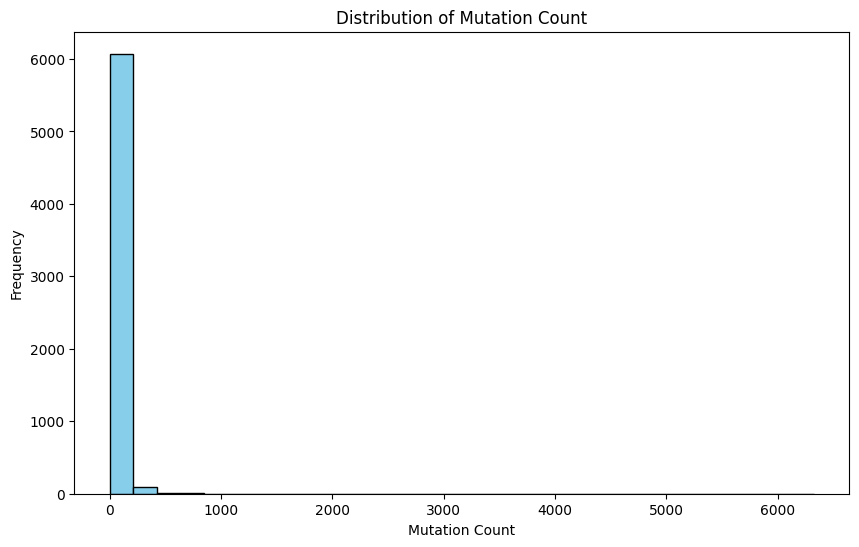

In [49]:
import matplotlib.pyplot as plt

# mutation_count 분포를 막대그래프로 시각화
plt.figure(figsize=(10, 6))
train['mutation_cnt'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title('Distribution of Mutation Count')
plt.xlabel('Mutation Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

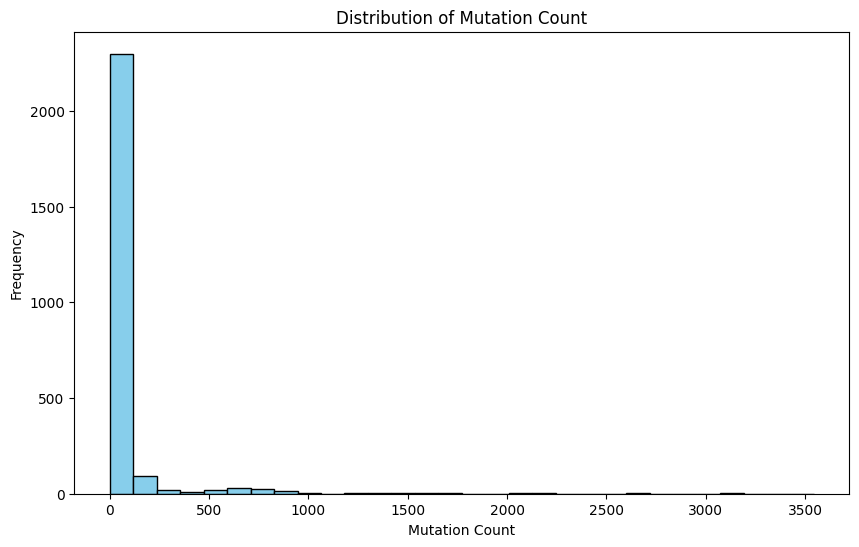

In [50]:
import matplotlib.pyplot as plt

# mutation_count 분포를 막대그래프로 시각화
plt.figure(figsize=(10, 6))
test['mutation_cnt'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title('Distribution of Mutation Count')
plt.xlabel('Mutation Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

In [51]:
# SUBCLASS별 mutation_count의 평균 계산
train_mutation_count = pd.DataFrame(train.groupby('SUBCLASS')['mutation_cnt'].mean())
train_mutation_count.sort_values(by='mutation_cnt', ascending=True)

mutation_cnt
SUBCLASS              
LAML          2.563291
PCPG          3.428571
THCA          3.432099
THYM          3.693878
PRAD          6.022556
LGG           7.109170
GBMLGG        9.902386
SARC         10.348485
KIRC         10.473054
OV           11.687747
KIPAN        12.625243
TGCT         12.677419
BRCA         15.122137
LIHC         24.234177
ACC          28.125000
HNSC         31.874439
CESC         36.503226
PAAD         42.050000
DLBC         46.236842
LUAD         46.913043
LUSC         54.853933
BLCA         55.567308
COAD         65.739910
STES         67.986807
SKCM        117.119565
UCEC        136.106061

### Subclass

SUBCLASS
BRCA      786
KIPAN     515
GBMLGG    461
STES      379
KIRC      334
THCA      324
SKCM      276
PRAD      266
OV        253
LGG       229
HNSC      223
COAD      223
UCEC      198
SARC      198
LUAD      184
LUSC      178
LIHC      158
LAML      158
CESC      155
PCPG      147
TGCT      124
PAAD      120
BLCA      104
THYM       98
ACC        72
DLBC       38
Name: count, dtype: int64


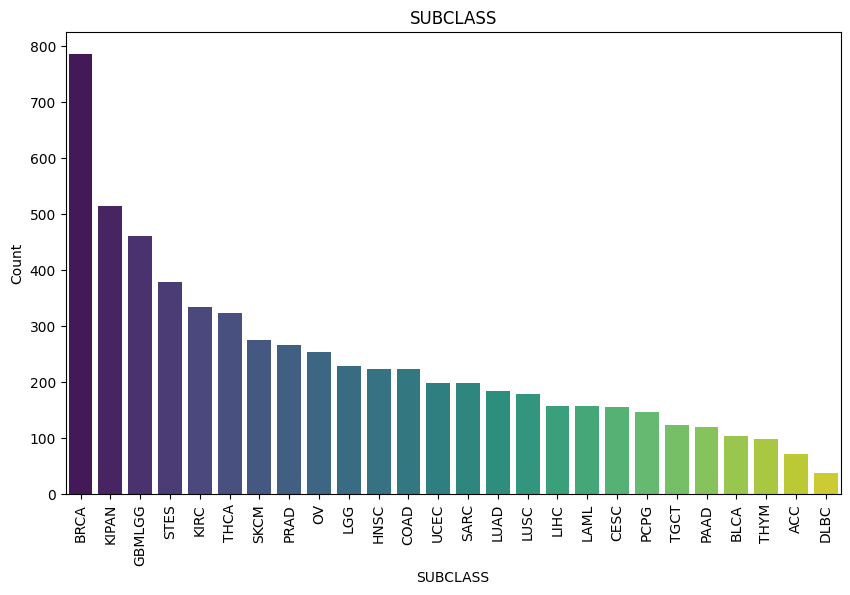

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# SUBCLASS 컬럼의 값 분포를 세는 코드
subclass_counts = train['SUBCLASS'].value_counts()

# 분포 출력
print(subclass_counts)

# 분포를 시각화하는 코드 (막대 그래프)
plt.figure(figsize=(10, 6))
sns.barplot(x=subclass_counts.index, y=subclass_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('SUBCLASS')
plt.xlabel('SUBCLASS')
plt.ylabel('Count')
plt.show()

In [55]:
random_seed = 42
np.random.seed(random_seed)

# 최상위 클래스에 해당하는 데이터만 필터링
top_class_rows = train[train['SUBCLASS'] == train['SUBCLASS'].value_counts().idxmax()]

# 이 중에서 150개의 샘플을 랜덤하게 선택하여 제거
rows_to_remove = top_class_rows.sample(n=150, random_state=random_seed)
train_dropped = train.drop(rows_to_remove.index)
train_dropped

ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...  ..  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10     ZWINT ZYX mutation_cnt  
0        WT     WT     WT    WT    WT   WT   WT        WT  WT           18  
1        WT     WT     WT    WT    WT   WT   WT        WT  WT           12  
2        WT     WT     WT    WT    WT   WT   WT        WT  WT           85  
3        WT     WT     WT    WT    WT   WT   WT        WT  WT            4  
4        WT     WT     WT    WT    WT   WT   WT        WT  WT           23  
...     ...    ...    ...   ...   ...  ...  ...       ...  ..          ...  
6196     WT     WT     WT    WT    WT   WT   WT        WT  WT           33  
6197     WT     WT     WT    WT    WT   WT   WT        WT  WT            8  
6198     WT     WT     WT    WT    WT   WT   WT  missense  WT           13  
6199     WT     WT     WT    WT    WT   WT   WT        WT  WT            5  
6200     WT     WT     WT    WT    WT   WT   WT        WT  WT           37  

[6051 rows x 4387 columns]

#### LabelEncoder

In [ ]:
# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25
